In [1]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [3]:
import splitfolders
import os
path = "/kaggle/input/hydrates-dataset/Hydrates dataset"
splitfolders.ratio(path,seed=1337, output="Hydrates_split", ratio=(0.6, 0.2, 0.2))

Copying files: 1169 files [00:08, 134.91 files/s]


In [4]:

train = '/kaggle/working/Hydrates_split/train'
val = '/kaggle/working/Hydrates_split/val'
test = '/kaggle/working/Hydrates_split/test'

# The shape of the RGB image
img_width, img_height, channels = 150, 150, 3  # you can try different sizes

# input shape
input_shape = (img_width, img_height, 3)
# position matters!
# Number_of_channels can be at the first or the last position
# in our case - "channels last"

# minibatch size
batch_size = 64
# train set size
nb_train_samples = 700
# validation set size
nb_validation_samples = 200
# test set size
nb_test_samples = 200

In [5]:
datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = datagen.flow_from_directory(
    test,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

train_generator = datagen.flow_from_directory(
    train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

val_generator = datagen.flow_from_directory(
    val,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 236 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
Found 233 images belonging to 2 classes.


In [6]:
import tensorflow as tf

# Enable DirectML backend
tf.config.experimental.enable_tensor_float_32_execution(False)

# ResNet50V2

In [7]:
from tensorflow.keras.applications import ResNet50V2

resnet_net = ResNet50V2(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
resnet_net.trainable = False

resnet_net.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 77, 77, 64)           0         ['conv1_conv[0][0]']          
                        

In [8]:
# Create a Sequential model
model = Sequential()

# Add the pre-trained ResNet50V2 model
model.add(resnet_net)

# Flatten the output of ResNet50V2
model.add(Flatten())

# Add a Dense layer with 512 neurons, ReLU activation, and Dropout for regularization
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Add another Dense layer with 256 neurons, ReLU activation, and Dropout for regularization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Add the final Dense layer with 1 neuron and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [10]:
fairy_tale = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs= 25,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size,
    workers=8)

/tmp/ipykernel_26/2543730722.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fairy_tale = model.fit_generator(


Epoch 1/25
10/10 [==============================] - 19s 547ms/step - loss: 1.4874 - accuracy: 0.5550 - val_loss: 0.4830 - val_accuracy: 0.7708
Epoch 2/25
10/10 [==============================] - 5s 394ms/step - loss: 0.8026 - accuracy: 0.7044 - val_loss: 0.2862 - val_accuracy: 0.8646
Epoch 3/25
10/10 [==============================] - 5s 383ms/step - loss: 0.5038 - accuracy: 0.7925 - val_loss: 0.2492 - val_accuracy: 0.8802
Epoch 4/25
10/10 [==============================] - 6s 401ms/step - loss: 0.4631 - accuracy: 0.8349 - val_loss: 0.2071 - val_accuracy: 0.9010
Epoch 5/25
10/10 [==============================] - 5s 366ms/step - loss: 0.3298 - accuracy: 0.8625 - val_loss: 0.1592 - val_accuracy: 0.9271
Epoch 6/25
10/10 [==============================] - 5s 381ms/step - loss: 0.3436 - accuracy: 0.8664 - val_loss: 0.1274 - val_accuracy: 0.9479
Epoch 7/25
10/10 [==============================] - 5s 370ms/step - loss: 0.2361 - accuracy: 0.9072 - val_loss: 0.1257 - val_accuracy: 0.9427
Epoch

In [11]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Accuracy on test data: %.2f%%" % (scores[1]*100))

/tmp/ipykernel_26/477001200.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)


Accuracy on test data: 97.40%


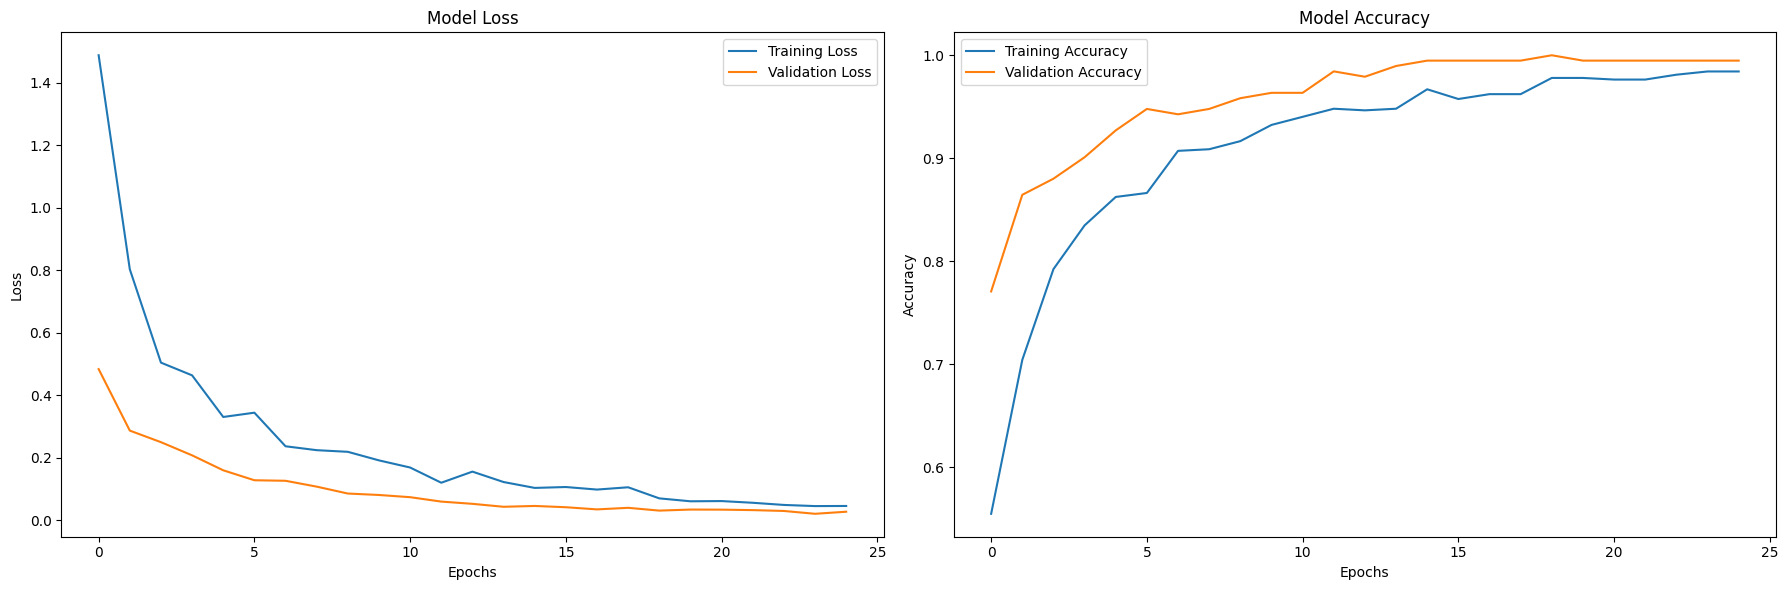

In [12]:
plt.figure(figsize=(18, 6))
# Plot Training & Validation Loss values
plt.subplot(1, 2, 1)
plt.plot(fairy_tale.history['loss'], label='Training Loss')
plt.plot(fairy_tale.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy values
plt.subplot(1, 2, 2)
plt.plot(fairy_tale.history['accuracy'], label='Training Accuracy')
plt.plot(fairy_tale.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()